In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import struct
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
# Define the model structures from the notebook
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, categorical_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, categorical_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

class Decoder(nn.Module):
    def __init__(self, categorical_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim, hidden_dim_2)
        self.fc2 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc3 = nn.Linear(hidden_dim_1, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Ensure output is within [0,1]
        return x

def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=False, dim=-1)
    return gs

# Given the typical input size for MNIST and FashionMNIST is 28x28
input_dim = 28 * 28
hidden_dim_1 = 800
hidden_dim_2 = 400
categorical_dim = 10  # Assuming 10 categories for simplicity

encoder = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim)
decoder = Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim)

# Check if GPU is available and move the models to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder, decoder


(Encoder(
   (fc1): Linear(in_features=784, out_features=800, bias=True)
   (fc2): Linear(in_features=800, out_features=400, bias=True)
   (fc3): Linear(in_features=400, out_features=10, bias=True)
 ),
 Decoder(
   (fc1): Linear(in_features=10, out_features=800, bias=True)
   (fc2): Linear(in_features=800, out_features=400, bias=True)
   (fc3): Linear(in_features=400, out_features=784, bias=True)
 ))

In [3]:
# Load the MNIST dataset
batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load a batch for testing
sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch.to(device)

sample_batch.shape


torch.Size([16, 784])

In [4]:
# Defining the sender and receiver for the signalling game

def sender(image):
    """
    Encodes the input image into a signal.
    """
    logits = encoder(image)
    signal = gumbel_softmax(logits, temperature=1.0)  # Using a fixed temperature for now
    return signal

def receiver(signal):
    """
    Decodes the signal into a predicted image.
    """
    predicted_image = decoder(signal)
    return predicted_image

# Testing the sender and receiver functions
sample_image = torch.rand((1, input_dim)).to(device)
signal = sender(sample_image)
predicted_image = receiver(signal)

signal.shape, predicted_image.shape


(torch.Size([1, 10]), torch.Size([1, 784]))

In [5]:
# Define the loss function for the signalling game
# criterion = nn.MSELoss()
# criterion = F.binary_cross_entropy()

def signalling_game_loss(original_image, decoded_image):
    """
    Computes the loss based on the difference between the original image and the decoded image.
    """
    return criterion(original_image, decoded_image)

def signalling_game_loss_batch(original_images, decoded_images):
    """
    Computes the loss based on the difference between the original image and the decoded image.
    """
    return F.binary_cross_entropy(decoded_images, original_images, reduction='sum') / original_images.shape[0]

# Testing the loss function with a sample
loss_sample = signalling_game_loss_batch(sample_image, predicted_image)
loss_sample
# signals = sender(sample_batch)
# decoded_images = receiver(signals)
# loss_sample_fixed = signalling_game_loss(sample_batch, decoded_images)
# loss_sample_fixed


tensor(543.9865, grad_fn=<DivBackward0>)

In [6]:
# Parameters and optimizer
learning_rate = 1e-3
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Training loop for the signalling game
num_epochs = 3
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        batch = batch.to(device)
        
        # Sender encodes the image
        signal = sender(batch)
        
        # Receiver decodes the signal
        decoded_image = receiver(signal)
        
        # Compute loss
        loss = signalling_game_loss_batch(batch, decoded_image)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.7f}")

losses


Epoch [1/3], Loss: 207.8222001
Epoch [2/3], Loss: 206.5492224
Epoch [3/3], Loss: 189.9701122


[207.8222000732422, 206.54922237141926, 189.9701121520996]

In [7]:

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from torch.nn import functional as F
# import struct
# import numpy as np
# import os
# import random

# # Encoder, Decoder and other utility functions from previous implementations
# ...  # (Code truncated for brevity)

# # Multi-agent interaction and evolution

# # Initialize multiple senders and receivers
# num_senders = 3
# num_receivers = 3

# senders = [Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device) for _ in range(num_senders)]
# receivers = [Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device) for _ in range(num_receivers)]

# # Parameters for the multi-agent interaction
# num_generations_multi = 5
# num_interactions_multi = 100

# # Main loop for generations with multiple senders and receivers
# ...

# import random

# # Parameters for the multi-agent interaction
# num_generations_multi = 5
# num_interactions_multi = 100

# # Track the performance over generations for multi-agent interactions
# performance_over_generations_multi = []

# # Main loop for generations with multiple senders and receivers
# for generation in range(num_generations_multi):
#     successful_interactions = 0
    
#     # Dynamic interactions within a generation
#     for interaction in range(num_interactions_multi):
#         # Randomly select a sender and a receiver
#         selected_sender = random.choice(senders)
#         selected_receiver = random.choice(receivers)
        
#         # Sample a random image
#         sample_image, _ = next(iter(train_loader))
#         sample_image = sample_image[0].to(device)
        
#         # Sender encodes the image
#         signal = selected_sender(sample_image.unsqueeze(0))
        
#         # Receiver decodes the signal
#         decoded_image = selected_receiver(signal)
        
#         # Check if the communication was successful
#         loss = signalling_game_loss(sample_image, decoded_image)
#         if loss < 0.1:  # Using a threshold to determine success
#             successful_interactions += 1
            
#         # Update the selected sender and receiver based on the result
#         optimizer_selected = optim.Adam(list(selected_sender.parameters()) + list(selected_receiver.parameters()), lr=learning_rate)
#         optimizer_selected.zero_grad()
#         loss.backward()
#         optimizer_selected.step()
    
#     # Store the performance for this generation
#     success_rate = successful_interactions / num_interactions_multi
#     performance_over_generations_multi.append(success_rate)
#     print(f"Generation {generation + 1}, Success Rate: {success_rate:.4f}")

# performance_over_generations_multi


In [8]:
# # Initialize a small population of agents
# initial_population = 2

# senders_population = [Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device) for _ in range(initial_population)]
# receivers_population = [Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device) for _ in range(initial_population)]

# # Growth rule: for simplicity, add one sender and one receiver at the end of each generation
# def grow_population(senders, receivers):
#     # New sender inherits strategy from a random existing sender with potential small mutation (omitted for simplicity here)
#     new_sender = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device)
#     new_sender.load_state_dict(random.choice(senders).state_dict())
    
#     # New receiver inherits strategy from a random existing receiver with potential small mutation (omitted for simplicity here)
#     new_receiver = Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device)
#     new_receiver.load_state_dict(random.choice(receivers).state_dict())
    
#     senders.append(new_sender)
#     receivers.append(new_receiver)

# # Check the initial population size
# len(senders_population), len(receivers_population)

# Modifying the growth rule to follow an exponential growth pattern

# Initialize a small population of agents
initial_population = 2

senders_population = [Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device) for _ in range(initial_population)]
receivers_population = [Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device) for _ in range(initial_population)]

# Growth rule: for simplicity, double the population at the end of each generation (exponential growth)
def grow_population(senders, receivers):
    current_population = len(senders)
    for _ in range(current_population):  # Double the current population
        # New sender inherits strategy from a random existing sender with potential small mutation (omitted for simplicity here)
        new_sender = Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device)
        new_sender.load_state_dict(random.choice(senders).state_dict())
        
        # New receiver inherits strategy from a random existing receiver with potential small mutation (omitted for simplicity here)
        new_receiver = Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device)
        new_receiver.load_state_dict(random.choice(receivers).state_dict())
        
        senders.append(new_sender)
        receivers.append(new_receiver)

# Check the initial population size
initial_population_sizes = (len(senders_population), len(receivers_population))
initial_population_sizes



(2, 2)

Generation 1, Success Rate: 0.0000, Population Size: 2
Generation 2, Success Rate: 0.0010, Population Size: 4
Generation 3, Success Rate: 0.0080, Population Size: 4
Generation 4, Success Rate: 0.0060, Population Size: 4
Generation 5, Success Rate: 0.0100, Population Size: 4
Generation 6, Success Rate: 0.0160, Population Size: 4
Generation 7, Success Rate: 0.0120, Population Size: 4
Generation 8, Success Rate: 0.0170, Population Size: 4
Generation 9, Success Rate: 0.0120, Population Size: 4
Generation 10, Success Rate: 0.0270, Population Size: 4


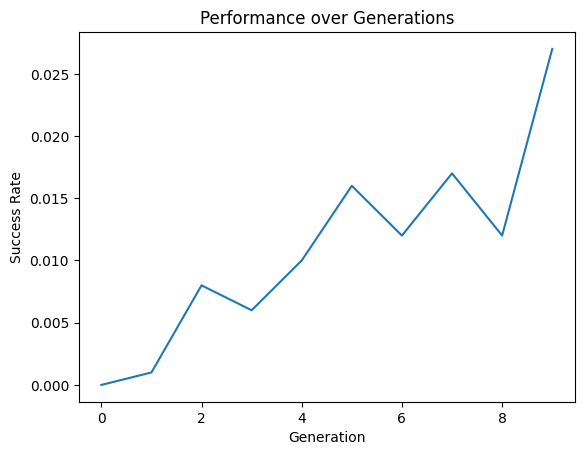

In [9]:
# Dynamic population interaction and evolution

# Parameters for the dynamic population interaction
num_generations_dynamic = 10
num_interactions_dynamic = 1000
learning_rate = 1e-3

# Track the performance and population size over generations for dynamic population interaction
performance_over_generations_dynamic = []
population_size_over_generations = []

# Main loop for generations with dynamic population growth
for generation in range(num_generations_dynamic):
    successful_interactions = 0
    
    # Dynamic interactions within a generation
    for interaction in range(num_interactions_dynamic):
        # Randomly select a sender and a receiver from the current population
        selected_sender = random.choice(senders_population)
        selected_receiver = random.choice(receivers_population)
        
        # Sample a random image
        sample_image, _ = next(iter(train_loader))
        sample_image = sample_image[0].to(device)
        
        # Sender encodes the image
        # signal = selected_sender(sample_image.unsqueeze(0))
        signal = selected_sender(sample_image)
        
        # Receiver decodes the signal
        decoded_image = selected_receiver(signal)
        
        # Check if the communication was successful
        loss = signalling_game_loss_batch(sample_image, decoded_image)
        if loss < 0.1:  # Using a threshold to determine success
            successful_interactions += 1
            
        # Update the selected sender and receiver based on the result
        optimizer_selected = optim.Adam(list(selected_sender.parameters()) + list(selected_receiver.parameters()), lr=learning_rate)
        optimizer_selected.zero_grad()
        loss.backward()
        optimizer_selected.step()
    
    # Store the performance for this generation
    success_rate = successful_interactions / num_interactions_dynamic
    performance_over_generations_dynamic.append(success_rate)
    
    # Track the population size
    population_size = len(senders_population)  # or len(receivers_population), they are the same
    population_size_over_generations.append(population_size)
    print(f"Generation {generation + 1}, Success Rate: {success_rate:.4f}, Population Size: {population_size}")

    # Apply the growth rule to increase the population
    if generation % 10 == 0:
        grow_population(senders_population, receivers_population)

performance_over_generations_dynamic, population_size_over_generations

# Plot the performance over generations
plt.plot(performance_over_generations_dynamic)
plt.xlabel("Generation")
plt.ylabel("Success Rate")
plt.title("Performance over Generations")
plt.show()

In [11]:
# Define a class for Agent which can act both as a sender and a receiver
class Agent:
    def __init__(self, encoder_model, decoder_model, lifespan=3):
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.lifespan = lifespan

# Initialize agents
initial_population = 2
agents_population = [Agent(Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device),
                               Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device)) 
                     for _ in range(initial_population)]

# Modified growth function
def grow_population_exponential(agents):
    current_population = len(agents)
    for _ in range(current_population):  # Double the current population
        # New agent
        new_agent = Agent(Encoder(input_dim, hidden_dim_1, hidden_dim_2, categorical_dim).to(device),
                              Decoder(categorical_dim, hidden_dim_2, hidden_dim_1, input_dim).to(device))
        agents.append(new_agent)

# Modified interaction loop with a check for agent population size
performance_over_generations_dynamic = []
population_size_over_generations = []

for generation in range(num_generations_dynamic):
    successful_interactions = 0
    
    # If there are less than 2 agents, skip the generation
    if len(agents_population) < 2:
        performance_over_generations_dynamic.append(0)  # No successful interactions
        population_size_over_generations.append(len(agents_population))
        continue
    
    # Every two agents interact once
    for i, agent1 in enumerate(agents_population):
        for j, agent2 in enumerate(agents_population):
            if i != j:  # An agent doesn't interact with itself
                # Sample a random image
                sample_image, _ = next(iter(train_loader))
                sample_image = sample_image[0].to(device)
                
                # Agent1 encodes the image
                signal = agent1.encoder(sample_image)
                
                # Agent2 decodes the signal
                decoded_image = agent2.decoder(signal)
                
                # Check if the communication was successful
                loss = signalling_game_loss_batch(sample_image, decoded_image)
                if loss < 0.1:
                    successful_interactions += 1
                
                # Update the agents based on the result
                optimizer_selected = optim.Adam(list(agent1.encoder.parameters()) + list(agent2.decoder.parameters()), lr=learning_rate)
                optimizer_selected.zero_grad()
                loss.backward()
                optimizer_selected.step()

    # Reduce lifespan and remove agents if lifespan is 0
    for agent in agents_population:
        agent.lifespan -= 1
    agents_population[:] = [agent for agent in agents_population if agent.lifespan > 0]
    
    # Store the performance for this generation
    print(f'generation {generation} successful_interactions: {successful_interactions}, agents_population: {len(agents_population)}')
    success_rate = successful_interactions / (len(agents_population) * (len(agents_population) - 1))  # (n * (n-1)) possible interactions
    performance_over_generations_dynamic.append(success_rate)
    
    # Track the population size
    population_size = len(agents_population)
    population_size_over_generations.append(population_size)
    
    # Apply the growth rule every 10 generations
    grow_population_exponential(agents_population)

performance_over_generations_dynamic, population_size_over_generations



generation 0 successful_interactions: 0, agents_population: 2
generation 1 successful_interactions: 0, agents_population: 4
generation 2 successful_interactions: 0, agents_population: 6
generation 3 successful_interactions: 0, agents_population: 10
generation 4 successful_interactions: 0, agents_population: 16
generation 5 successful_interactions: 0, agents_population: 26
generation 6 successful_interactions: 0, agents_population: 42
generation 7 successful_interactions: 0, agents_population: 68
generation 8 successful_interactions: 0, agents_population: 110
generation 9 successful_interactions: 1, agents_population: 178


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1739986034406146e-05],
 [2, 4, 6, 10, 16, 26, 42, 68, 110, 178])